In [1]:
using Flux
using OrdinaryDiffEq
using Plots
using SciMLSensitivity

In [2]:
using Lux, ComponentArrays, Random

In [3]:
mb, mw, cs, ct, ds, dt = rand(6)
rng = Random.default_rng()

function inp(t)
    return rand()
end



NN_1 = Lux.Chain(Lux.Dense(1, 16, tanh), Lux.Dense(16, 1))
p1, st1 = Lux.setup(rng, NN_1)
NN_2 = Lux.Chain(Lux.Dense(1, 16, tanh), Lux.Dense(16, 1))
p2, st2 = Lux.setup(rng, NN_2)


p1 = ComponentArray(p1)
p2 = ComponentArray(p2)

p = ComponentArray{eltype(p1)}()
p = ComponentArray(p; p1)
p = ComponentArray(p; p2)

function linear_qvm(du, u, p, t)
    zb, vb, zw, vw, zr = u
    inpt = inp(t) # inp(t) is u(t) in paper
    Δvs = vw - vb
    Δzs = zw - zb
    Δzt = zr - zw
    Δvt = inpt - vw
    NN_ct = NN_1([Δzs], p.p1, st1)[1][1]
    NN_dt = NN_2([Δvs], p.p2, st2)[1][1]
    du[1] = vb
    du[2] = 1/mb * (cs * Δzs + ds * Δvs + NN_ct + NN_dt) # ab
    du[3] = vw
    du[4] = 1/mw * (ct * Δzt + dt * Δvt - cs * Δzs - ds * Δvs - NN_ct - NN_dt) # aw
    du[5] = inpt
end

linear_qvm (generic function with 1 method)

In [4]:
u0 = rand(5)
tspan = (0.0, 1.0)
prob_nn = ODEProblem(linear_qvm, u0, tspan, p)
sol = solve(prob_nn, Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 1163-element Vector{Float64}:
 0.0
 0.005987093134982707
 0.008917193436148496
 0.011267873736581991
 0.01331829074726118
 0.015280419705862074
 0.01699043310576278
 0.01874388436172716
 0.020910018219902505
 0.022620077962081122
 ⋮
 0.9924154141434579
 0.9932737679455876
 0.9940903967000143
 0.9949715539052342
 0.9959472998165328
 0.996964330149511
 0.9978998693411744
 0.9992188701381585
 1.0
u: 1163-element Vector{Vector{Float64}}:
 [0.7539914128669233, 0.13575193736813485, 0.4629754684692594, 0.7294208955288326, 0.23778653579468156]
 [0.7548232397844835, 0.14204879007179683, 0.46731405990108665, 0.7181832311051766, 0.23814932756395862]
 [0.7552437524545433, 0.14496210810933957, 0.469410349197217, 0.7151402393662857, 0.23968455859653995]
 [0.7555872224995444, 0.14725952400916759, 0.47108892372912614, 0.7083889558709896, 0.23834784784850566]
 [0.7558911467122059, 0.14918631116942338, 0.47253905160669796, 0.7

In [5]:
function predict(θ)
    Array(solve(prob_nn, Tsit5(), p = θ, saveat = sol.t,
        abstol = 1e-6, reltol = 1e-6,
        sensealg = InterpolatingAdjoint(autojacvec = ReverseDiffVJP(true))))
end

X = rand(length(u0), length(sol.t))

function loss(θ)
    pred = predict(θ)
    sum(abs2, X .- pred), pred
end

loss (generic function with 1 method)

In [6]:
using Optimization, OptimizationOptimisers, OptimizationOptimJL

In [73]:
const losses = []
callback(θ, l, pred) = begin
    push!(losses, l)
    if length(losses) % 50 == 0
        println(losses[end])
    end
    false
end
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)

optprob = Optimization.OptimizationProblem(optf, p)
res1_uode = Optimization.solve(optprob, OptimizationOptimisers.Adam(0.01),
    callback = callback, maxiters = 100)

# optprob2 = Optimization.OptimizationProblem(optf, res1_uode.u)
# res2_uode = Optimization.solve(optprob2, OptimizationOptimJL.BFGS(), maxiters = 10000,
#     callback = callback)

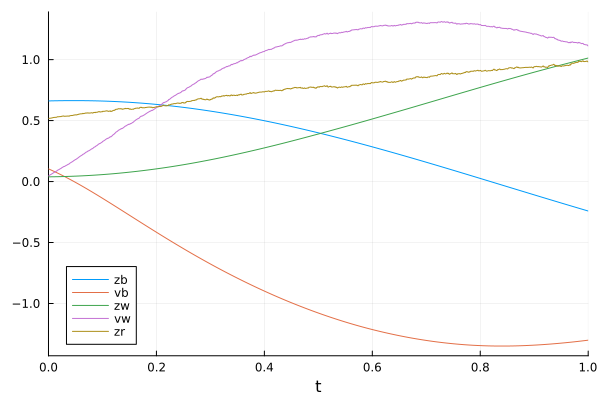

In [62]:
plot(sol, label = ["zb" "vb" "zw" "vw" "zr"])